# PCA FOR PREDICTION OF "Target"

To improve our model, we will try to apply PCA for each of our model to know whether we will apply PCA in the final model or not.

We will first deciding how much principal component we use, and apply the PCA on the training dataset on different models, via pipelin to avoid data leakage.

Importation of libraries

In [6]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [8]:
!pip install xgboost
!pip install catboost
!pip install lightgbm

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

Loading our pre-created dataset (SMOTE and original versions, to use them according the tested model)

In [12]:
X_train = pd.read_csv("X_train.csv")
y_train_full = pd.read_csv("y_train.csv")
y_train = y_train_full['Target']

X_train_smote = pd.read_csv("X_train_resampled_target.csv")
y_train_resampled = pd.read_csv("y_train_resampled_target.csv")
y_train_smote = y_train_resampled['Target']

Recall of the covariance matrix : 

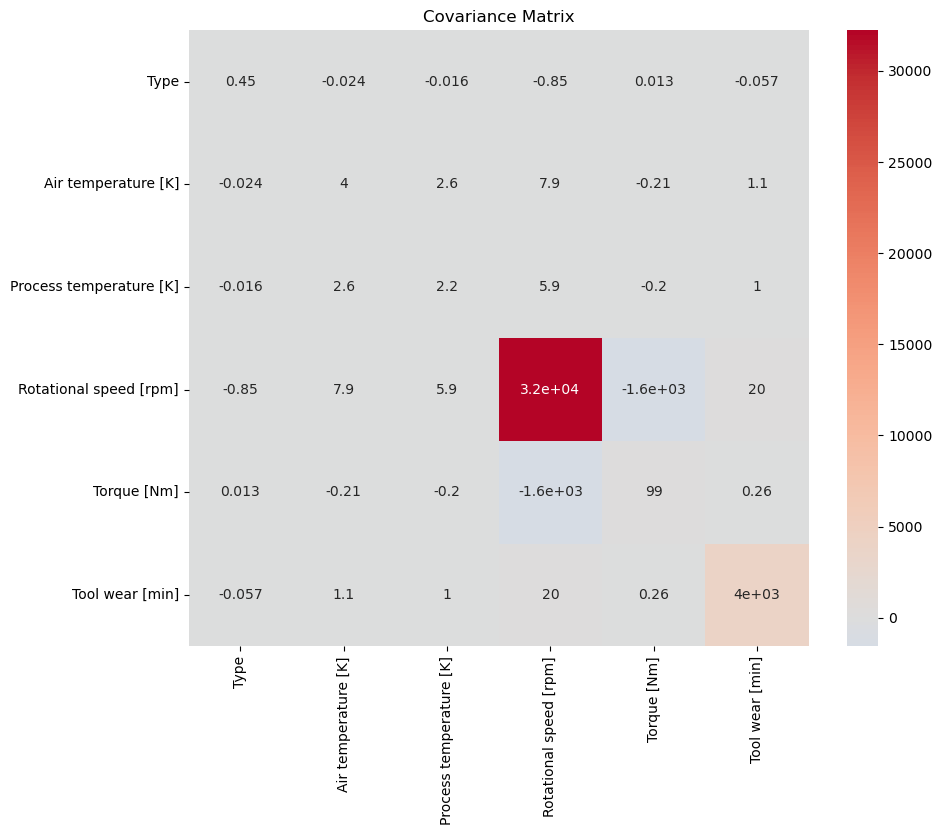

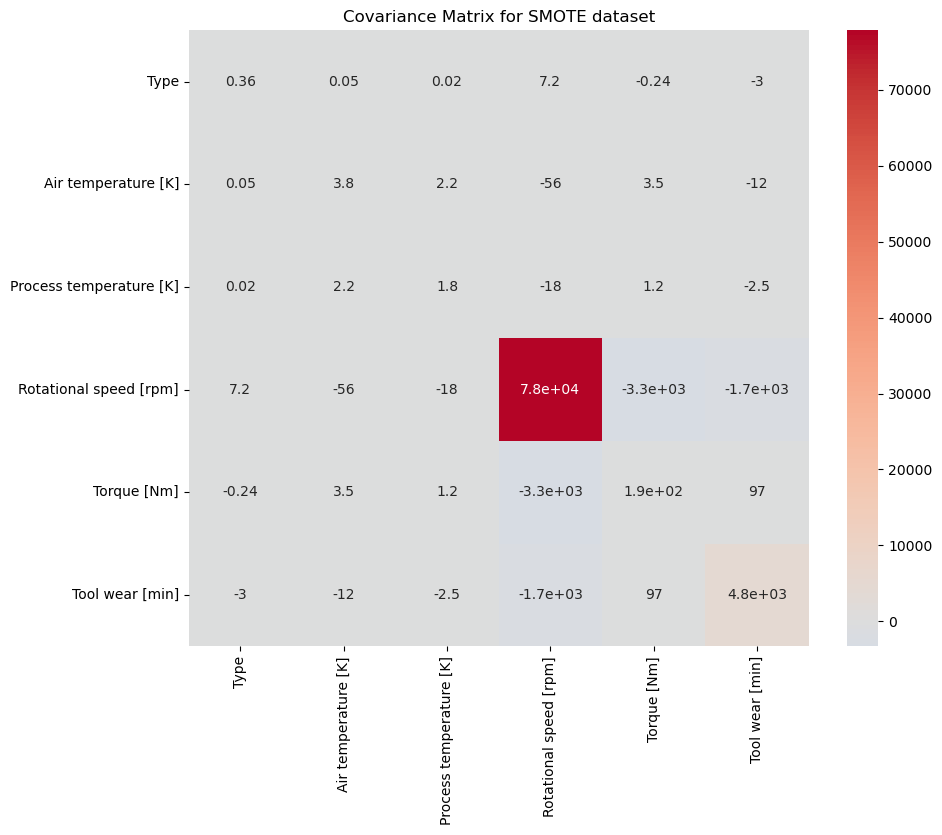

In [6]:
cov_matrix = np.cov(X_train, rowvar=False)

numeric_cols = ['Type','Air temperature [K]','Process temperature [K]',
                'Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', center=0, xticklabels=numeric_cols, yticklabels=numeric_cols)
plt.title('Covariance Matrix')
plt.show()

cov_matrix_smote = np.cov(X_train_smote, rowvar=False)

plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix_smote, annot=True, cmap='coolwarm', center=0, xticklabels=numeric_cols, yticklabels=numeric_cols)
plt.title('Covariance Matrix for SMOTE dataset')
plt.show()

Even if they don't have the same order of magnitude, in both covariance matrix the values seems to evolve the same.

In PCA, we know that feature with higher variance and the features that have the higher covariance are going to be the principal components, so here we can guess that Rotational speed [rpm] is going to be the first pca, and Tool Wear [min] after.

For original dataset, Rotational speed [rpm] and Tool Wear [min] are also the features that have the highest value of covariance with any other feature. 
In SMOTE dataset, they also have the highest values of covariance but negatives so evolving in opposite way.

We will try with 1 PCA then with 2 PCAs, not more given the low covariance and variance that there are from other features.

Checking the relevance for 2 PCAs instead of more:

In [7]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
print("Explained variance ratio for original dataset: ",pca.explained_variance_ratio_)
print("Cumuled explained variance ratio for original dataset: ",pca.explained_variance_ratio_.cumsum())

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_smote)
print("Explained variance ratio for SMOTE dataset: ",pca.explained_variance_ratio_)
print("Cumuled explained variance ratio for original dataset: ",pca.explained_variance_ratio_.cumsum())

Explained variance ratio for original dataset:  [0.88863126 0.11055402]
Cumuled explained variance ratio for original dataset:  [0.88863126 0.99918528]
Explained variance ratio for SMOTE dataset:  [0.94170765 0.05758069]
Cumuled explained variance ratio for original dataset:  [0.94170765 0.99928834]


We already obtain a high explained variance near 100% with only 2 PCAs (for og dataset and smote one) so we will only try with 2 PCAs.

Creating the pipelines to test each model: one time with 1 pca and one time with 2 pcas.
- First models are tested with SMOTE dataset 
- Second models are tested with original dataset 

In [18]:
pca_components = 0.95  #basic value

In [19]:
def restore_cols(X):
    return pd.DataFrame(X, columns=[f"f{i}" for i in range(X.shape[1])])

In [20]:
#stocking our different pipelines in a dict: first, the models using smote dataset
pipelines_smote = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=pca_components)),
        ("clf", LogisticRegression(max_iter=500)) #500 because 100 was not enough to converge
    ]),
    
    "SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=pca_components)),
        ("clf", SVC(kernel="rbf"))
    ]),
    
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=pca_components)),
        ("clf", KNeighborsClassifier(n_neighbors=5)) #default value
    ]),
    
    "Neural Network (MLP)": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=pca_components)),
        ("clf", MLPClassifier(hidden_layer_sizes=(64, 32),
                              activation="relu",
                              max_iter=500)) #to have as much iteration as for logistic regression
    ])
}

#weight class for CatBoost preidiction:
counts = np.bincount(y_train) 
total = len(y_train)
n_classes = len(counts)
class_weigth_catboost = [total / (n_classes * c) if c != 0 else 1.0 for c in counts]

#weight class ratio for XGBoost
num_neg = sum(y_train == 0)
num_pos = sum(y_train == 1)
ratio = num_neg / num_pos


#stocking our different pipelines in a second dict: the models using original datase
pipelines = {
    
    "DecisionTree": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=pca_components)), 
        ("rename", FunctionTransformer(restore_cols)), #very important for LightGBM to work
        ("model", DecisionTreeClassifier(
            criterion="gini", 
            max_depth=None,
            min_samples_split=2,
            class_weight='balanced'
        ))
    ]),

    "RandomForest": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=pca_components)),
        ("rename", FunctionTransformer(restore_cols)), #very important for LightGBM to work
        ("model", RandomForestClassifier(
            n_estimators=300, #more than the default value
            class_weight='balanced',#compensate with imbalanced dataset
            criterion="gini",
            max_depth=None
        ))
    ]),

    "XGBoost": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=pca_components)),
        ("rename", FunctionTransformer(restore_cols)), #very important for LightGBM to work
        ("model", XGBClassifier(
            n_estimators=300,
            max_depth=6,
            scale_pos_weight=ratio, #compensate with imbalanced dataset
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="logloss",
            tree_method="hist"   #found to be the more optimal parameters here
        ))
    ]),

    "CatBoost": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=pca_components)),
        ("rename", FunctionTransformer(restore_cols)), #very important for LightGBM to work
        ("model", CatBoostClassifier(
            iterations=300,
            depth=6,
            learning_rate=0.05,
            verbose=None,
            class_weights=class_weigth_catboost,
            logging_level="Silent" #to not print each step..
        ))
    ]),

    "LightGBM": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=pca_components)),
        ("rename", FunctionTransformer(restore_cols)), #very important for LightGBM to work
        ("model", LGBMClassifier(
            n_estimators=300,
            learning_rate=0.05, #more precise learning than 0.1
            max_depth=-1, #so that we don't set a limit
            subsample=0.8, #avoid overfitting
            colsample_bytree=0.8, #avoid overfitting 
            verbose=-1,
            class_weight='balanced'
        ))
    ])
}

We wanted to try multiple values for our number of splits (3, 5 then 10) to check for the stability of the model and if its accuracy stays, but given the high number of models to test first we will only try with n = 5 at first.

In [21]:
k = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [22]:
results = {} #stocking the results to print them

#call pipeline with different models and evaluating them
for name, model in pipelines_smote.items():
    results[name] = {}
    print(f"\n{name}, for 1 Principal Component:")
    pca_components = 1
    scores = cross_val_score(model, X_train_smote, y_train_smote, cv=k, scoring="recall")
    print(f"Recall: {scores.mean():.4f}")
    print(f"Standard deviation: {scores.std():.4f}")
    results[name][1] = np.mean(scores)
    
    pca_components = 2
    print(f"\n{name}, for 2 Principal Components:")
    scores = cross_val_score(model, X_train_smote, y_train_smote, cv=k, scoring="recall")
    print(f"Recall: {scores.mean():.4f}")
    print(f"Standard deviation: {scores.std():.4f}")
    results[name][2] = np.mean(scores)

    
for name, model in pipelines.items():
    results[name] = {}
    pca_components = 1
    print(f"\n{name}, for 1 Principal Component:")
    scores = cross_val_score(model, X_train, y_train, cv=k, scoring="recall")
    print(f"Recall: {scores.mean():.4f}")
    print(f"Standard deviation: {scores.std():.4f}")
    results[name][1] = np.mean(scores)
    
    pca_components = 2
    scores = cross_val_score(model, X_train, y_train, cv=k, scoring="recall")
    print(f"\n{name}, for 2 Principal Components:")
    print(f"Recall: {scores.mean():.4f}")
    print(f"Standard deviation: {scores.std():.4f}")
    results[name][2] = np.mean(scores)
    


Logistic Regression, for 1 PCA:
Recall: 0.7548
Standard deviation: 0.0083

Logistic Regression, for 2 PCAs:
Recall: 0.7548
Standard deviation: 0.0083

SVM, for 1 PCA:
Recall: 0.9656
Standard deviation: 0.0045

SVM, for 2 PCAs:
Recall: 0.9656
Standard deviation: 0.0045

KNN, for 1 PCA:
Recall: 0.9789
Standard deviation: 0.0068

KNN, for 2 PCAs:
Recall: 0.9789
Standard deviation: 0.0068

Neural Network (MLP), for 1 PCA:
Recall: 0.9638
Standard deviation: 0.0062

Neural Network (MLP), for 2 PCAs:
Recall: 0.9722
Standard deviation: 0.0072

DecisionTree, for 1 PCA:
Recall: 0.3064
Standard deviation: 0.0563

DecisionTree, for 2 PCAs:
Recall: 0.3064
Standard deviation: 0.0525

RandomForest, for 1 PCA:
Recall: 0.2435
Standard deviation: 0.0210

RandomForest, for 2 PCAs:
Recall: 0.2362
Standard deviation: 0.0180

XGBoost, for 1 PCA:
Recall: 0.5757
Standard deviation: 0.0581

XGBoost, for 2 PCAs:
Recall: 0.5757
Standard deviation: 0.0581

CatBoost, for 1 PCA:
Recall: 0.7380
Standard deviation: 

To compare with the results of the first prediction (without PCAs):

In [23]:
results_df = pd.DataFrame(results)
print(results_df)

   Logistic Regression       SVM       KNN  Neural Network (MLP)  \
1             0.754768  0.965615  0.978851              0.963800   
2             0.754768  0.965615  0.978851              0.972233   

   DecisionTree  RandomForest  XGBoost  CatBoost  LightGBM  
1      0.306397      0.243502  0.57569   0.73798  0.520539  
2      0.306397      0.236162  0.57569   0.73798  0.520539  


Final comparison of each model based on their Recall value for each value of k fold

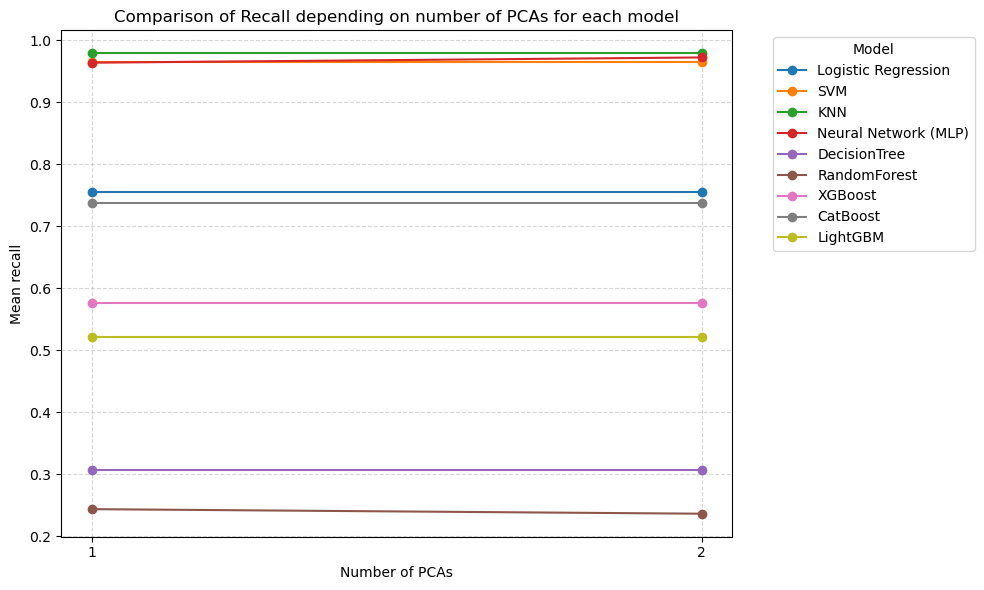

In [24]:
plt.figure(figsize=(10, 6))

for name in results.keys():
    pcas = list(results[name].keys())
    recalls = list(results[name].values())
    plt.plot(pcas, recalls, marker="o", label=name)

plt.title("Comparison of Recall depending on number of PCAs for each model")
plt.xlabel("Number of PCAs")
plt.ylabel("Mean recall")
plt.xticks([1,2])
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


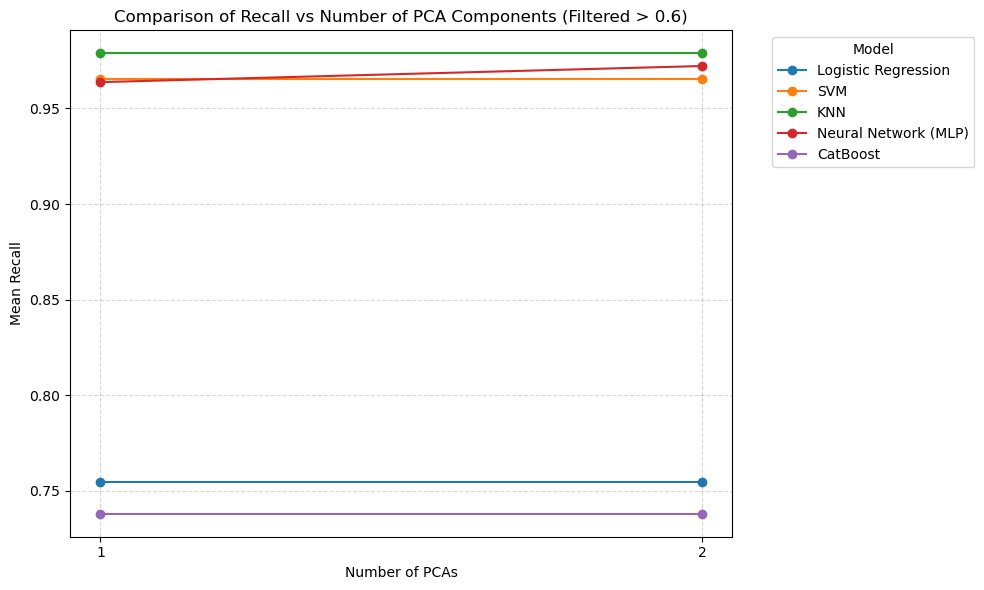

In [25]:
plt.figure(figsize=(10, 6))

for name, values in results.items():
    pcas = list(values.keys())
    recalls = list(values.values())
    if max(recalls) > 0.6:
        plt.plot(pcas, recalls, marker="o", label=name)

plt.title("Comparison of Recall vs Number of PCA Components (Filtered > 0.6)")
plt.xlabel("Number of PCAs")
plt.ylabel("Mean Recall")
plt.xticks([1, 2])
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Analysis

We notice that for ensemble models, PCA is irrelevant and not pertinent because it reduces dimension and avoid decision by threshold and tree.
So for ensemble models, we will not use PCAs. 

For the simple models, which use SMOTE, there is no big difference between 1 or 2 PCAS, but it rise the Mean Recall for Neural Network model.
We compared the result with the one found without PCAs (notebook "First models for Target prediction")

As saw in the first prediction for Target, we will keep the models KNN, Neural Network and LightGBM.

It can be relevant to apply PCAs on KNN and Neural Network. However, for k=5 which was already tested on the First prediction, values of recall for these models are lower so PCA will not be relevant. (0.972233 < 0.98 for NN, 0.978851 < 0.98 for KNN)

We decided to not apply PCA on this prediction (Target).

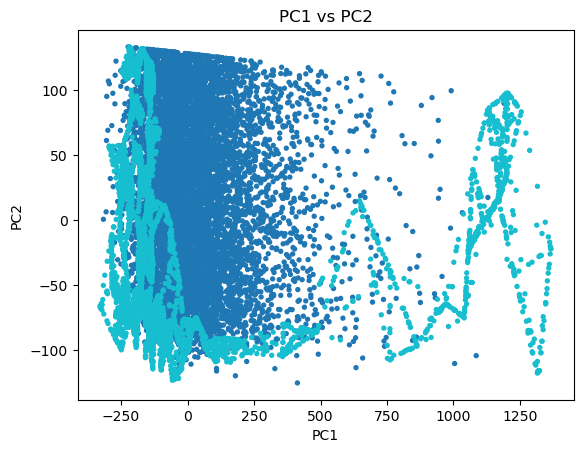

In [21]:
X_pca = PCA(n_components=2).fit_transform(X_train_smote)  
import matplotlib.pyplot as plt
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_train_smote, s=8, cmap='tab10')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('PC1 vs PC2')
plt.show()

Indeed, there is not a linear separation between classes.